# MimickNet_Mobile TF Training Pipeline


In [42]:
!curl ipecho.net/plain

35.204.88.141

## Initialize path and options

In [43]:
train_with_sep = False

In [44]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab/MimickNet_Mobile

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/Colab/MimickNet_Mobile'
/content/gdrive/My Drive/Colab/MimickNet_Mobile


## Get dependencies

In [45]:
%%capture
# Install libraries
!pip3 install tensorflow
!pip3 install tensorflow_datasets
!pip3 install tensorflow_addons==0.8.3
!pip3 install polarTransform

In [46]:
%%capture
# Load Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

# Import helpers
from trainer.config import config
from trainer import utils
from trainer import models
from trainer import callbacks
from trainer.utils import *
from trainer.models import MimickNet_Conv
from trainer.models import MimickNet_SepConv

## Checking versions and Misc things

In [47]:
# Checking versions and misc things
print(tf.__version__)
print(tfa.__version__)
LOG_DIR = "./log_dir"
MODEL_DIR = config.model_dir
print(LOG_DIR)
print(MODEL_DIR)

%rm -r trained_models
%mkdir trained_models

2.4.1
0.8.3
./log_dir
./trained_models


## Load Dataset and split into train, validation, and test

In [48]:
""" MimickDataset """
class MimickDataset():
    def __init__(self, divisible, bs, dataset, data_dir):
        self.divisible = divisible
        self.bs = bs
        self.dataset = dataset
        self.data_dir = data_dir

    def make_dataset(self, dataset_type):
        ds = tfds.load(self.dataset, data_dir=self.data_dir)
        dataset = ds[dataset_type]
        dataset = dataset.map(process)
        if (dataset_type == 'train' or dataset_type == 'validation'):
            dataset = dataset.map(make_shape_to_dimension, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
            dataset = dataset.batch(self.bs).repeat().prefetch(1)
        else:
            dataset = dataset.map(make_divisible, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
            dataset = dataset.batch(1).repeat().prefetch(1)
        dataset = dataset.apply(tf.data.experimental.prefetch_to_device("/gpu:0", buffer_size=1))
        return dataset

In [49]:
# Create datasets (Train, Validation, Test)
mimick = MimickDataset(divisible=16, bs=config.bs, dataset='duke_ultrasound', data_dir='gs://tfds-data/datasets')

# Information taken from https://www.tensorflow.org/datasets/catalog/duke_ultrasound
train_count = 2556
test_count = 438
val_count = 278

# Make datasets
train_dataset = mimick.make_dataset(dataset_type='train')
validation_dataset = mimick.make_dataset(dataset_type='validation')
test_dataset = mimick.make_dataset(dataset_type='test')

## Load Model

In [50]:
# Load Model with No Separable Convolutions
# Reset tf session
tf.keras.backend.clear_session()

if train_with_sep == False:
    model = MimickNet_Conv.MimickNet_Conv(shape=(512,512,1),Activation=tf.keras.layers.ReLU(),filters=[16,16,16,16,16], filter_shape=(3,3)).load_model()
else:
    model = MimickNet_SepConv.MimickNet_SepConv(shape=(512,512,1),Activation=tf.keras.layers.ReLU(),filters=[16,16,16,16,16], filter_shape=(3,3)).load_model()

model.compile(optimizer=tf.keras.optimizers.Adam(0.002), loss='mae', 
              metrics=[utils.mae, utils.mse, utils.ssim, utils.psnr])
# model.summary()

## Generate Callbacks

In [51]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, write_graph=True, update_freq='epoch')
copy_keras = callbacks.CopyKerasModel(MODEL_DIR, LOG_DIR)
saving = tf.keras.callbacks.ModelCheckpoint(MODEL_DIR + '/model.{epoch:02d}-{val_ssim:.10f}.hdf5', 
                                            monitor='val_ssim', verbose=1, save_freq='epoch', mode='max', save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.002*.001)
log_code = callbacks.LogCode(LOG_DIR, './trainer')
terminate = tf.keras.callbacks.TerminateOnNaN()
image_gen = callbacks.GenerateImages(model, validation_dataset, LOG_DIR, interval=int(train_count/config.bs))

## Train and Save Model

In [52]:
model.fit(train_dataset,
          steps_per_epoch=int(train_count/config.bs),
          epochs=int(config.epochs/10),
          validation_data=validation_dataset,
          validation_steps=int(val_count/config.bs),
          verbose=1,
          callbacks=[log_code, terminate, tensorboard, saving, reduce_lr, copy_keras])
#           callbacks=[log_code, terminate, tensorboard, saving, reduce_lr, copy_keras])

Epoch 1/10
  6/319 [..............................] - ETA: 5:18 - loss: 0.2112 - mae: 0.2112 - mse: 0.0669 - ssim: 0.4081 - psnr: 15.1615

319/319 [==============================] - 58s 168ms/step - loss: 0.0591 - mae: 0.0591 - mse: 0.0080 - ssim: 0.8681 - psnr: 25.3552 - val_loss: 0.0495 - val_mae: 0.0495 - val_mse: 0.0045 - val_ssim: 0.9219 - val_psnr: 26.9167

Epoch 00001: val_ssim improved from -inf to 0.92187, saving model to ./trained_models/model.01-0.9218668938.hdf5
Epoch 2/10
319/319 [==============================] - 27s 84ms/step - loss: 0.0385 - mae: 0.0384 - mse: 0.0026 - ssim: 0.9231 - psnr: 28.3847 - val_loss: 0.0475 - val_mae: 0.0475 - val_mse: 0.0040 - val_ssim: 0.9292 - val_psnr: 27.1031

Epoch 00002: val_ssim improved from 0.92187 to 0.92917, saving model to ./trained_models/model.02-0.9291676879.hdf5
Epoch 3/10
319/319 [==============================] - 27s 84ms/step - loss: 0.0372 - mae: 0.0372 - mse: 0.0024 - ssim: 0.9293 - psnr: 28.7633 - val_loss: 0.0467 - val_mae: 0.0467 - val_mse: 0.0038 - val_ssim: 0.9309 - val_psnr: 27.3476

Epoch 00003: val_ssim improved from 0.92917 to 0.93093, saving model t

In [53]:
# Save the entire model as a SavedModel.
model_file_name = "tflite_model"
model.save(f'{model_file_name}')

INFO:tensorflow:Assets written to: tflite_model/assets


# MimickNet_Mobile TFLite Training and Inference Pipeline


## Generate TFLite Model

In [54]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_file_name) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

## Test inference with TFLite model

In [55]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [56]:
# Load test elements
test_iter = iter(test_dataset)
test_ele = next(test_iter)

In [57]:
#@title Function to convert image dimensions to desired dimensions {form-width:"20%"}
def make_shape(image, shape=None, divisible=16, seed=0):
    """Will reflection pad or crop to make an image divisible by a number.
    
    If shape is smaller than the original image, it will be cropped randomly
    If shape is larger than the original image, it will be refection padded
    If shape is None, the image's original shape will be minimally padded to be divisible by a number.
    
    Arguments:
        image {np.array} -- np.array that is (height, width, channels)
    
    Keyword Arguments:
        shape {tuple} -- shape of image desired (default: {None})
        seed {number} -- random seed for random cropping (default: {0})
        divisible {number} -- number to be divisible by (default: {16})
    
    Returns:
        np.array, (int, int) -- divisible image no matter the shape, and a tuple of the original size.
    """

    np.random.seed(seed=seed)
    image_height = image.shape[0]
    image_width = image.shape[1]

    shape = shape if shape is not None else image.shape
    height = shape[0] if shape[0] % divisible == 0 else (divisible - shape[0] % divisible) + shape[0]
    width = shape[1] if shape[1] % divisible == 0 else (divisible - shape[1] % divisible) + shape[1]

    # Pad data to batch height and width with reflections, and randomly crop
    if image_height < height:
        remainder = height - image_height
        if remainder % 2 == 0:
            image = np.pad(image, ((int(remainder/2), int(remainder/2)), (0,0)), 'reflect')
        else:
            remainder = remainder - 1
            image = np.pad(image, ((int(remainder/2) + 1, int(remainder/2)), (0,0)), 'reflect')
    elif image_height > height:
        start = np.random.randint(0, image_height - height)
        image = image[start:start+height, :]

    if image_width < width:
        remainder = width - image_width
        if remainder % 2 == 0:
            image = np.pad(image, ((0,0), (int(remainder/2), int(remainder/2))), 'reflect')
        else:
            remainder = remainder - 1
            image = np.pad(image, ((0,0), (int(remainder/2) + 1, int(remainder/2))), 'reflect')
    elif image_width > width:
        start = np.random.randint(0, image_width - width)
        image = image[:, start:start+width]
    image = image[:,:, None]
    
    return image, (image_height, image_width)

In [58]:
# Test the model on a test input data.
input_shape_tflite = input_details[0]['shape']
input_data_tflite = np.array(test_ele['das'], dtype=np.float32)
input_data_tflite = np.squeeze(input_data_tflite)
input_data_tflite, _ = make_shape(input_data_tflite, shape=(512,512,1))
input_data_tflite = np.expand_dims(input_data_tflite, axis=0)
interpreter.set_tensor(input_details[0]['index'], input_data_tflite)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data_tflite = interpreter.get_tensor(output_details[0]['index'])

In [59]:
# Create truth image
truth_tflite = np.array(test_ele['dtce'], dtype=np.float32)
truth_tflite = np.squeeze(truth_tflite)
truth_tflite, _ = make_shape(truth_tflite, shape=(512,512,1))
truth_tflite = np.expand_dims(truth_tflite, axis=0)

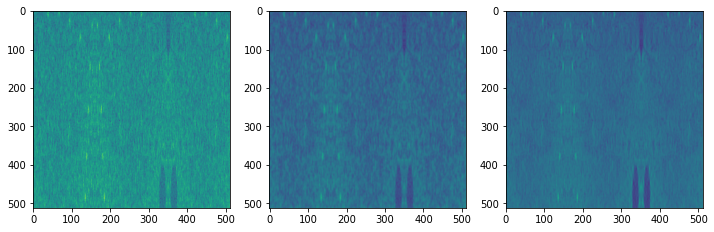

In [60]:
fig, ax = plt.subplots(1,3, figsize=(12,12))
ax[0].imshow(np.squeeze(input_data_tflite), vmin=0, vmax=1)
ax[1].imshow(np.squeeze(output_data_tflite), vmin=0, vmax=1)
ax[2].imshow(np.squeeze(truth_tflite), vmin=0, vmax=1)

## Test Inference with Tensorflow

In [ ]:
# Test the model on a test input data.
input_data_tf = np.array(input_data_tflite)
output_data_tf = model.predict(input_data_tf)

# Create truth table 
truth_tf = np.array(truth_tflite)

## Comparison of TF and TFLite Inference

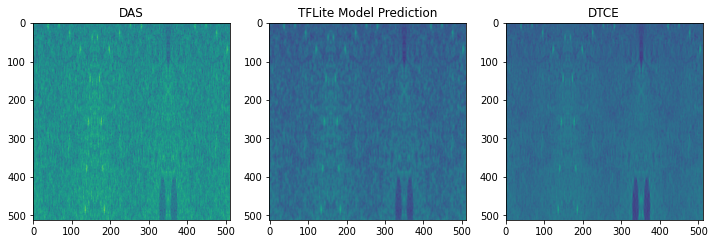

In [71]:
#@title Checking TFLite Model Plots {form-width:"20%"}
fig, ax = plt.subplots(1,3, figsize=(12,12))
ax[0].title.set_text('DAS')
ax[0].imshow(np.squeeze(input_data_tflite), vmin=0, vmax=1)
ax[1].title.set_text('TFLite Model Prediction')
ax[1].imshow(np.squeeze(output_data_tflite), vmin=0, vmax=1)
ax[2].title.set_text('DTCE')
ax[2].imshow(np.squeeze(truth_tflite), vmin=0, vmax=1)

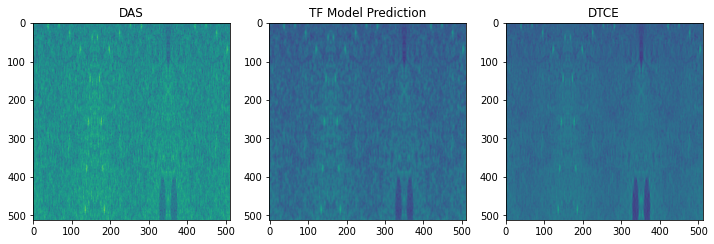

In [72]:
#@title Checking TF Model Plots {form-width:"20%"}
fig, ax = plt.subplots(1,3, figsize=(12,12))
ax[0].title.set_text('DAS')
ax[0].imshow(np.squeeze(input_data_tf), vmin=0, vmax=1)
ax[1].title.set_text('TF Model Prediction')
ax[1].imshow(np.squeeze(output_data_tf), vmin=0, vmax=1)
ax[2].title.set_text('DTCE')
ax[2].imshow(np.squeeze(truth_tf), vmin=0, vmax=1)

In [63]:
#@title Checking TFLite statistics {form-width:"20%"}
ssim_input_output = utils.ssim(input_data_tflite, output_data_tflite)
psnr_input_output = utils.psnr(input_data_tflite, output_data_tflite)
mse_input_output = utils.mse(input_data_tflite, output_data_tflite)
ssim_das_dtce = utils.ssim(truth_tflite, output_data_tflite)
psnr_das_dtce = utils.psnr(truth_tflite, output_data_tflite)
mse_das_dtce = utils.mse(truth_tflite, output_data_tflite)

# print(f"Input - Output Comparison Check (TFLite)")
# print(f"SSIM: {ssim_input_output}, PSNR: {psnr_input_output}, MSE: {mse_input_output}")
print(f"Truth - Output Comparison Check (TFLite)")
print(f"SSIM: {ssim_das_dtce}, PSNR: {psnr_das_dtce}, MSE: {mse_das_dtce}")

Truth - Output Comparison Check (TFLite)
SSIM: [0.9559563], PSNR: [35.865986], MSE: [0.00025906]


In [64]:
#@title Checking TF statistics {form-width:"20%"}
ssim_input_output = utils.ssim(input_data_tf, output_data_tf)
psnr_input_output = utils.psnr(input_data_tf, output_data_tf)
mse_input_output = utils.mse(input_data_tf, output_data_tf)
ssim_das_dtce = utils.ssim(truth_tf, output_data_tf)
psnr_das_dtce = utils.psnr(truth_tf, output_data_tf)
mse_das_dtce = utils.mse(truth_tf, output_data_tf)

# print(f"Input - Output Comparison Check (TF)")
# print(f"SSIM: {ssim_input_output}, PSNR: {psnr_input_output}, MSE: {mse_input_output}")
print(f"Truth - Output Comparison Check (TF)")
print(f"SSIM: {ssim_das_dtce}, PSNR: {psnr_das_dtce}, MSE: {mse_das_dtce}")

Truth - Output Comparison Check (TF)
SSIM: [0.9559563], PSNR: [35.865986], MSE: [0.00025906]
